In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPool2D
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

In [2]:
train_data = pd.read_csv('dataset.csv')
#default label 0 = glaucoma 1 = normal 2 = others
train_data.loc[train_data.label == 2, 'label'] = 0
train_data['label'] = train_data['label'].astype(str)
Y = train_data[['label']]
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 

idg = ImageDataGenerator(rescale = 1./255,
                        shear_range = 0.2,
                        zoom_range = 0.2,
                        horizontal_flip = True)

In [3]:
def create_new_model():
    IMAGE_SIZE = [32, 32]
    vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    for layer in vgg.layers:
        layer.trainable = False
    x = Flatten()(vgg.output)
    prediction = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=vgg.input, outputs=prediction)
    return model

def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [4]:
def main():
    VALIDATION_ACCURACY = []
    VALIDATION_LOSS = []
    
    image_dir = 'dataset'
    save_dir = 'nsaved_models/'
    fold_var = 1
    num_epochs = 15
    
    for train_index, val_index in skf.split(np.zeros(4044),Y):

        training_data = train_data.iloc[train_index]
        validation_data = train_data.iloc[val_index]
        
        train_data_generator = idg.flow_from_dataframe(training_data, directory = image_dir,
                                                       x_col = 'filename', y_col = 'label',
                                                       target_size = (32, 32),batch_size = 16,
                                                       class_mode = "binary", shuffle = True)
        valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = image_dir,
                                                        x_col = 'filename', y_col = 'label',
                                                        target_size = (32, 32),batch_size = 16,
                                                        class_mode = "binary", shuffle = True)
        # CREATE NEW MODEL
        model = create_new_model()

        # COMPILE NEW MODEL
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        # CREATE CALLBACKS
        checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir + get_model_name(fold_var),
                                                        monitor='val_accuracy', verbose=1,
                                                        save_best_only=True, mode='max')
        callbacks_list = [checkpoint]
        
        # There can be other callbacks, but just showing one because it involves the model name
        # This saves the best model

        # FIT THE MODEL
        history = model.fit_generator(train_data_generator,
                            epochs=15,
                            callbacks=callbacks_list,
                            validation_data=valid_data_generator)
        
        # Extract valid_data_generator
        valid_data_generator.reset()
        
        X_test, y_test = next(valid_data_generator)
        
        batch_index = 0
        while batch_index <= valid_data_generator.batch_index:
            img, label = next(valid_data_generator)
            X_test = np.append(X_test, img, axis=0 )
            y_test = np.append(y_test, label, axis=0)
            batch_index = batch_index + 1
        
                
        # PLOT HISTORY        
        y_pred = model.predict(X_test).ravel()
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
        
        from sklearn.metrics import auc
        auc_keras = auc(fpr_keras, tpr_keras)
        
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label='ROC fold {} (AUC = {:.2f})'.format(fold_var,auc_keras))

        # LOAD BEST MODEL to evaluate the performance of the model
        model.load_weights("nsaved_models/model_" + str(fold_var) + ".h5")

        results = model.evaluate(valid_data_generator)
        results = dict(zip(model.metrics_names, results))
        
                
        VALIDATION_ACCURACY.append(results['accuracy'])
        VALIDATION_LOSS.append(results['loss'])
        
        tf.keras.backend.clear_session()
        
        fold_var += 1
        
    plt.xlabel('False Positive Rate (Positive label: 1)')
    plt.ylabel('True Positive Rate (Positive label: 1)')
    plt.title('Receiver operating characteristic')
    plt.legend(loc='best')
    plt.savefig('Graph/vgg16_normal_graph.jpg')
    plt.show()  

Found 3235 validated image filenames belonging to 2 classes.
Found 809 validated image filenames belonging to 2 classes.


c:\users\vivet\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
203/203 [==============================] - 19s 80ms/step - loss: 0.6507 - accuracy: 0.5975 - val_loss: 0.5949 - val_accuracy: 0.6452

Epoch 00001: val_accuracy improved from -inf to 0.64524, saving model to nsaved_models\model_1.h5
Epoch 2/15
203/203 [==============================] - 28s 139ms/step - loss: 0.5802 - accuracy: 0.6624 - val_loss: 0.5713 - val_accuracy: 0.6885

Epoch 00002: val_accuracy improved from 0.64524 to 0.68850, saving model to nsaved_models\model_1.h5
Epoch 3/15
203/203 [==============================] - 47s 230ms/step - loss: 0.5703 - accuracy: 0.6902 - val_loss: 0.5679 - val_accuracy: 0.6910

Epoch 00003: val_accuracy improved from 0.68850 to 0.69098, saving model to nsaved_models\model_1.h5
Epoch 4/15
203/203 [==============================] - 44s 219ms/step - loss: 0.5640 - accuracy: 0.6820 - val_loss: 0.5469 - val_accuracy: 0.7169

Epoch 00004: val_accuracy improved from 0.69098 to 0.71693, saving model to nsaved_models\model_1.h5
Epoch 5/15
203/2

c:\users\vivet\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
203/203 [==============================] - 65s 316ms/step - loss: 0.6848 - accuracy: 0.5479 - val_loss: 0.6070 - val_accuracy: 0.6378

Epoch 00001: val_accuracy improved from -inf to 0.63782, saving model to nsaved_models\model_2.h5
Epoch 2/15
203/203 [==============================] - 48s 237ms/step - loss: 0.6039 - accuracy: 0.6354 - val_loss: 0.5717 - val_accuracy: 0.7033

Epoch 00002: val_accuracy improved from 0.63782 to 0.70334, saving model to nsaved_models\model_2.h5
Epoch 3/15
203/203 [==============================] - 48s 235ms/step - loss: 0.5766 - accuracy: 0.6992 - val_loss: 0.5678 - val_accuracy: 0.6959

Epoch 00003: val_accuracy did not improve from 0.70334
Epoch 4/15
203/203 [==============================] - 49s 240ms/step - loss: 0.5571 - accuracy: 0.6985 - val_loss: 0.5557 - val_accuracy: 0.7145

Epoch 00004: val_accuracy improved from 0.70334 to 0.71446, saving model to nsaved_models\model_2.h5
Epoch 5/15
203/203 [==============================] - 47s 232

c:\users\vivet\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
203/203 [==============================] - 46s 215ms/step - loss: 0.6562 - accuracy: 0.5795 - val_loss: 0.5961 - val_accuracy: 0.6675

Epoch 00001: val_accuracy improved from -inf to 0.66749, saving model to nsaved_models\model_3.h5
Epoch 2/15
203/203 [==============================] - 43s 214ms/step - loss: 0.5943 - accuracy: 0.6663 - val_loss: 0.5740 - val_accuracy: 0.6922

Epoch 00002: val_accuracy improved from 0.66749 to 0.69221, saving model to nsaved_models\model_3.h5
Epoch 3/15
203/203 [==============================] - 44s 215ms/step - loss: 0.5778 - accuracy: 0.6844 - val_loss: 0.5641 - val_accuracy: 0.6613

Epoch 00003: val_accuracy did not improve from 0.69221
Epoch 4/15
203/203 [==============================] - 43s 214ms/step - loss: 0.5768 - accuracy: 0.6632 - val_loss: 0.5472 - val_accuracy: 0.7070

Epoch 00004: val_accuracy improved from 0.69221 to 0.70705, saving model to nsaved_models\model_3.h5
Epoch 5/15
203/203 [==============================] - 44s 215

c:\users\vivet\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
203/203 [==============================] - 45s 217ms/step - loss: 0.6599 - accuracy: 0.5783 - val_loss: 0.6215 - val_accuracy: 0.6316

Epoch 00001: val_accuracy improved from -inf to 0.63164, saving model to nsaved_models\model_4.h5
Epoch 2/15
203/203 [==============================] - 43s 205ms/step - loss: 0.5950 - accuracy: 0.6486 - val_loss: 0.5994 - val_accuracy: 0.6452

Epoch 00002: val_accuracy improved from 0.63164 to 0.64524, saving model to nsaved_models\model_4.h5
Epoch 3/15
203/203 [==============================] - 43s 214ms/step - loss: 0.5727 - accuracy: 0.6763 - val_loss: 0.5738 - val_accuracy: 0.6811

Epoch 00003: val_accuracy improved from 0.64524 to 0.68109, saving model to nsaved_models\model_4.h5
Epoch 4/15
203/203 [==============================] - 44s 215ms/step - loss: 0.5703 - accuracy: 0.6890 - val_loss: 0.5646 - val_accuracy: 0.6811

Epoch 00004: val_accuracy did not improve from 0.68109
Epoch 5/15
203/203 [==============================] - 44s 217

c:\users\vivet\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
203/203 [==============================] - 47s 229ms/step - loss: 0.7384 - accuracy: 0.5014 - val_loss: 0.6259 - val_accuracy: 0.5941

Epoch 00001: val_accuracy improved from -inf to 0.59406, saving model to nsaved_models\model_5.h5
Epoch 2/15
203/203 [==============================] - 43s 215ms/step - loss: 0.6018 - accuracy: 0.6417 - val_loss: 0.5957 - val_accuracy: 0.6646

Epoch 00002: val_accuracy improved from 0.59406 to 0.66460, saving model to nsaved_models\model_5.h5
Epoch 3/15
203/203 [==============================] - 44s 216ms/step - loss: 0.5739 - accuracy: 0.6894 - val_loss: 0.5910 - val_accuracy: 0.6597

Epoch 00003: val_accuracy did not improve from 0.66460
Epoch 4/15
203/203 [==============================] - 43s 214ms/step - loss: 0.5654 - accuracy: 0.6858 - val_loss: 0.5938 - val_accuracy: 0.6498

Epoch 00004: val_accuracy did not improve from 0.66460
Epoch 5/15
203/203 [==============================] - 43s 214ms/step - loss: 0.5489 - accuracy: 0.7221 - va

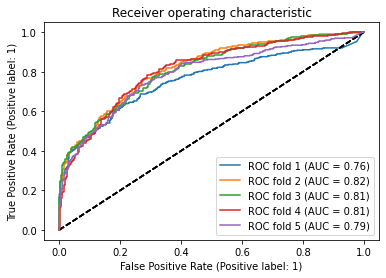

In [5]:
main()